In [1]:
#import packages

import re 
import pickle


import pandas as pd
import numpy as np
import json

import pprint
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict


from wordcloud import WordCloud


import gensim 
from gensim import corpora

C:\Users\Yakki\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
with open('data/yelp-dataset/yelp_academic_dataset_business.json',encoding="utf8") as fp: #请保持data/yelp-dataset/xxxx 的路径，方便交流
    lines = fp.readlines()

In [3]:
list_ = []
for i_line in lines:
    list_.append(json.loads(i_line))
df_business = pd.DataFrame(list_)
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 15 columns):
address         188593 non-null object
attributes      162807 non-null object
business_id     188593 non-null object
categories      188052 non-null object
city            188593 non-null object
hours           143791 non-null object
is_open         188593 non-null int64
latitude        188587 non-null float64
longitude       188587 non-null float64
name            188593 non-null object
neighborhood    188593 non-null object
postal_code     188593 non-null object
review_count    188593 non-null int64
stars           188593 non-null float64
state           188593 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 21.6+ MB


In [4]:
df_business = df_business[(df_business['city']=='Toronto')
                          | (df_business['city']=='Las Vegas')
                          | (df_business['city']=='Cleveland')
                          | (df_business['city']=='Montréal')]
print('with NaN', df_business.shape)
print('withou NaN', df_business.dropna().shape)
df_business.dropna(inplace=True)
print('Number of business', len(df_business['business_id'].unique()))
df_business

with NaN (56649, 15)
withou NaN (38117, 15)
Number of business 38117


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
11,595 Markham Street,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",tZnSodhPwNr4bzrwJ1CSbw,"Cajun/Creole, Southern, Restaurants",Toronto,"{'Tuesday': '17:0-1:0', 'Wednesday': '17:0-1:0...",0,43.664125,-79.411886,Southern Accent Restaurant,Palmerston,M6G 2L7,146,4.0,ON
16,438 Place Jacques Cartier,"{'Alcohol': 'full_bar', 'BikeParking': 'True',...",r89Re4FNgVWHgBfjCVZyVw,"Nightlife, Bars, American (Traditional), Tapas...",Montréal,"{'Monday': '11:30-23:0', 'Tuesday': '11:30-23:...",0,45.507699,-73.553407,Harlow,Ville-Marie,H2Y 3B3,12,3.5,QC
19,"3940 Martin Luther King Blvd, Ste 101","{'BikeParking': 'True', 'BusinessAcceptsCredit...",vJIuDBdu01vCA8y1fwR1OQ,"American (Traditional), Food, Bakeries, Restau...",Las Vegas,"{'Tuesday': '11:0-18:0', 'Wednesday': '11:0-18...",0,36.192284,-115.159272,CakesbyToi,,89106,3,1.5,NV
23,746 Street Clair Avenue W,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",5J3b7j3Fzo9ISjChmoUoUA,"Food, Bakeries, Coffee & Tea",Toronto,"{'Monday': '7:30-19:0', 'Tuesday': '7:30-19:0'...",1,43.681328,-79.427884,Mabel's Bakery,Wychwood,M6C 1B5,23,4.0,ON
32,2255 N Rampart Blvd,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",kgffcoxT6BQp-gJ-UQ7Czw,"Fast Food, Restaurants, Sandwiches",Las Vegas,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",1,36.201794,-115.281981,Subway,Summerlin,89128,13,2.5,NV
33,2227 N Rampart Blvd,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",0jtRI7hVMpQHpUVtUy4ITw,"Beer, Wine & Spirits, Italian, Food, American ...",Las Vegas,"{'Monday': '7:0-14:30', 'Tuesday': '7:0-19:0',...",1,36.201990,-115.283122,Omelet House Summerlin,Summerlin,89128,242,4.0,NV
37,15828 Euclid Ave,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",qHF2s8U2yzPLgIOGH_IMBw,"Seafood, Restaurants",Cleveland,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",1,41.541571,-81.569901,John John's Seafood,Collamer,44112,3,4.5,OH
44,"2101 S Decatur Blvd, Ste 11","{'BikeParking': 'True', 'BusinessAcceptsCredit...",0i6GlR5YTCMlwthjqw6ZTQ,"Hair Salons, Beauty & Spas",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.148658,-115.209813,Cinthya's Beauty Salon,Westside,89102,16,4.5,NV
45,"3111 S Valley View Blvd, Unit B120","{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",oSS0p8TeF9BTTD7QWtO6gg,"Flooring, Cabinetry, Refinishing Services, Hom...",Las Vegas,"{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",1,36.131640,-115.190826,Aria Remodeling,Westside,89102,3,5.0,NV


In [5]:
with open('data/yelp-dataset/yelp_academic_dataset_tip.json',encoding="utf8") as fp:
    json_tip = fp.readlines()

In [7]:
list_tip = []
for i_line in json_tip:
    list_tip.append(json.loads(i_line))
df_tip = pd.DataFrame(list_tip)
df_tip

,business_id,date,likes,text,user_id
0,tJRDll5yqpZwehenzE2cSg,2012-07-15,0,Get here early enough to have dinner.,zcTZk7OG8ovAmh_fenH21g
1,2ThtBbeDqFkVi6LugUOcVA,2012-11-25,0,Don't use them! Double charged my boyfriend an...,M5n8mMFoeXjnJEV2gxyGGA
2,jH19V2I9fIslnNhDzPmdkA,2015-08-12,0,Great breakfast large portions and friendly wa...,ZcLKXikTHYOnYt5VYRO5sg
3,dAa0hB2yrnHzVmsCkN4YvQ,2014-06-20,0,Nice place. Great staff. A fixture in the tow...,oaYhjqBbh18ZhU0bpyzSuw
4,dAa0hB2yrnHzVmsCkN4YvQ,2016-10-12,0,Happy hour 5-7 Monday - Friday,ulQ8Nyj7jCUR8M83SUMoRQ
5,ESzO3Av0b1_TzKOiqzbQYQ,2017-01-28,0,"Parking is a premium, keep circling, you will ...",ulQ8Nyj7jCUR8M83SUMoRQ
6,k7WRPbDd7rztjHcGGkEjlw,2017-02-25,0,Homemade pasta is the best in the area,ulQ8Nyj7jCUR8M83SUMoRQ
7,k7WRPbDd7rztjHcGGkEjlw,2017-04-08,0,"Excellent service, staff is dressed profession...",ulQ8Nyj7jCUR8M83SUMoRQ
8,SqW3igh1_Png336VIb5DUA,2016-07-03,0,Come early on Sunday's to avoid the rush,ulQ8Nyj7jCUR8M83SUMoRQ
9,KNpcPGqDORDdvtekXd348w,2016-01-07,0,Love their soup!,ulQ8Nyj7jCUR8M83SUMoRQ


In [ ]:
#1.In different cities,who is the activest user and where he has been indicated on the map

In [8]:
len(df_tip)

1185348

In [9]:
#merge two dataframe
newtip_df=pd.merge(df_tip,df_business,on='business_id')
newtip_df

,business_id,date,likes,text,user_id,address,attributes,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,QFPS9JBNdOOHVP0C3pSslw,2012-08-22,0,"The place to go after work, but, it ain't cheap",TvkqJ8YEIsTb16RnnrNyfQ,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
1,QFPS9JBNdOOHVP0C3pSslw,2011-09-07,0,Patio! Drink Specials!,CxDOIDnH8gp9KXzpBHJYXw,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
2,QFPS9JBNdOOHVP0C3pSslw,2013-01-04,0,Wednesday special ( 3pm to close). House brewe...,-_2h2cJlBOWAYrfplMU-Cg,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
3,QFPS9JBNdOOHVP0C3pSslw,2013-02-08,0,Pizza is really good... Give it a try.,-_2h2cJlBOWAYrfplMU-Cg,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
4,QFPS9JBNdOOHVP0C3pSslw,2013-07-29,0,Nice after work trendy atmosphere. Decent pric...,z_wzj26NrLbdqVMdgyTjsA,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
5,QFPS9JBNdOOHVP0C3pSslw,2012-03-15,0,Love Earl's but it is a little too noisy !,O0_payJa3UGpM6lh5QyDBQ,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
6,QFPS9JBNdOOHVP0C3pSslw,2012-01-20,0,Why on a Friday is this a female's paradise? ...,j_CSgnUN4km4TLu4ENi_JA,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
7,QFPS9JBNdOOHVP0C3pSslw,2013-01-16,0,Snotty service unless you're wearing a suit.,74goFJSWzAwmk69XfPqEag,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
8,QFPS9JBNdOOHVP0C3pSslw,2013-02-15,0,Was just informed that they use models as wait...,74goFJSWzAwmk69XfPqEag,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON
9,QFPS9JBNdOOHVP0C3pSslw,2013-05-13,0,Pleasant attentive service. Sante Fe salad ver...,663n1STTNekdHSX4Yd_MOQ,"150 King Street West, Unit 100","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Bars, Nightlife, Ameri...",Toronto,"{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'...",1,43.648013,-79.383925,Earls Kitchen + Bar,Financial District,V5H 1J9,354,3.5,ON


In [10]:
#for user 
df_T=newtip_df[(newtip_df['city']=='Toronto')]
df_L=newtip_df[(newtip_df['city']=='Las Vegas')]
df_C=newtip_df[(newtip_df['city']=='Cleveland')]
df_M=newtip_df[(newtip_df['city']=='Montréal')]
  

In [11]:
#find activest user 
def finduser(data):
    user_dict={}
    for each in data['user_id']:
        if each not in user_dict.keys():
            user_dict.update({each:1})
        else:
            user_dict[each]+=1
    #maximum = max(user_dict.values())
    #keys = filter(lambda x:user_dict[x] == maximum,user_dict.keys())
    key_max = max(user_dict.keys(), key=(lambda k: user_dict[k]))
    return key_max


In [13]:
#Find out where the user has been 
def places(user,data):
    places={}
    newdf=data[(data['user_id']==user)]
    newdf=newdf[['name','latitude','longitude','text']]
    
    return newdf


In [44]:
#active user
activeT=finduser(df_T)
activeL=finduser(df_L)
activeC=finduser(df_C)
activeM=finduser(df_M)
print(activeT,activeL,activeC,activeM)
placeT=places(activeT,newtip_df).drop_duplicates()
placeL=places(activeL,newtip_df).drop_duplicates()
placeC=places(activeC,newtip_df).drop_duplicates()
placeM=places(activeM,newtip_df).drop_duplicates()
placeT.head()

CxDOIDnH8gp9KXzpBHJYXw 6ZC-0LfOAGwaFc5XPke74w NfU0zDaTMEQ4-X9dbQWd9A Wc5L6iuvSNF5WGBlqIO8nw


,name,latitude,longitude,text
1,Earls Kitchen + Bar,43.648013,-79.383925,Patio! Drink Specials!
13531,Great Lakes Brewing Company,41.484399,-81.704521,$1.50 per sample or $16for everything on tap
14552,Sansotei Ramen,43.655004,-79.386473,Only 630 pm and they sold out? Up for business...
25608,The Black Bull,43.649634,-79.393307,Nice patio!
28067,Pai Northern Thai Kitchen,43.647866,-79.388642,Patio is open! Have a beer and some spicy Thai...


In [122]:
#not run
import folium
m = folium.Map(location=[40.8075,-73.9626],zoom_start=100)
folium.Marker([40.8075,-73.9626],popup="Columbia University").add_to(m)

In [18]:
def createmap(data):
    import folium
    #m = folium.Map(location=[45.372, -121.6972],zoom_start=12,tiles='Stamen Terrain',,tiles='http://tile.'+'stamen.com/toner/{z}/{x}/{y}.png ')
    name=str(data['name'].iloc[0])
    m=folium.Map(location=[data['latitude'].iloc[0],data['longitude'].iloc[0]],zoom_start=11)
    #m=folium.Map(location=[data['latitude'].iloc[0],data['longitude'].iloc[0]],tiles=str(data['name'].iloc[0]),zoom_start=12,attr=str(data['name'].iloc[0]))
    for i in range(len(data))[1:]:
        #folium.Marker([data['latitude'].iloc[i],data['longitude'].iloc[i]],popup=data.iloc[i]['name']).add_to(m)
        folium.Marker([data['latitude'].iloc[i],data['longitude'].iloc[i]]).add_to(m)
    return m
   

In [19]:
createmap(placeT)

In [126]:
createmap(placeL)

In [127]:
createmap(placeC)

In [128]:
createmap(placeM)

In [ ]:
#based on df_tip 1.In different cities,who is the activest tip user and where he has been indicated on the map
#2.for that user to do sentiment analysis based on his tip in the end give a word_cloud chart 
#To verify whether his tip is fair

In [ ]:
# placeT=places(activeT,newtip_df).drop_duplicates()
# placeL=places(activeL,newtip_df).drop_duplicates()
# placeC=places(activeC,newtip_df).drop_duplicates()
# placeM=

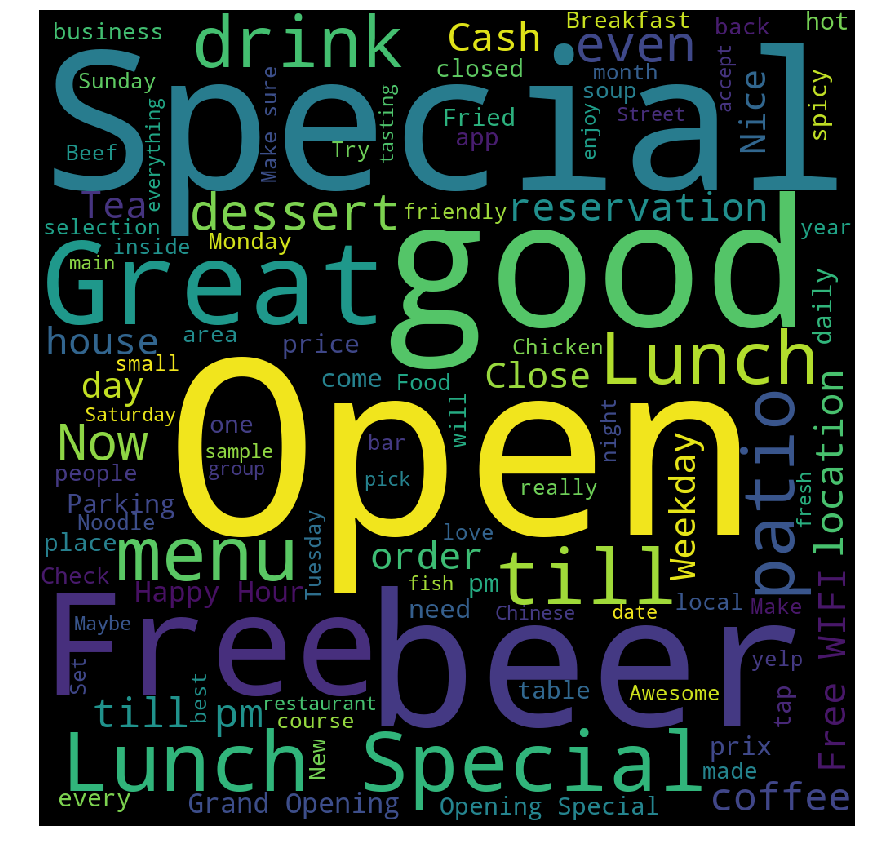

In [133]:
cloud = WordCloud(width=1000, height= 1000,max_words= 100).generate(' '.join(placeT['text']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');

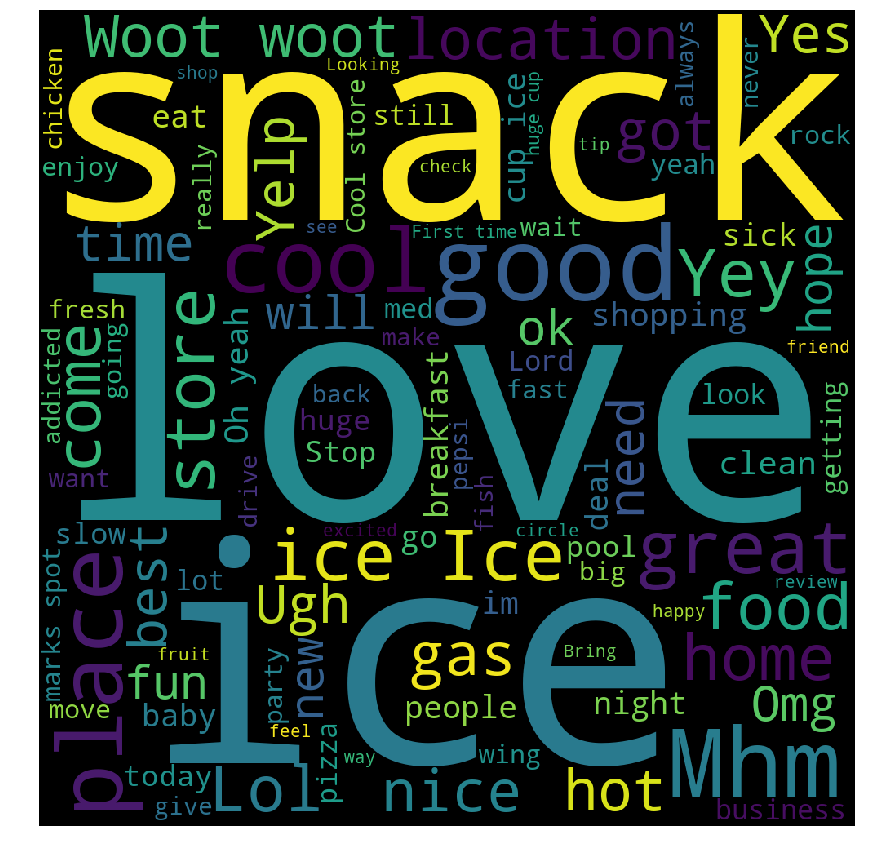

In [134]:
cloud = WordCloud(width=1000, height= 1000,max_words= 100).generate(' '.join(placeL['text']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');

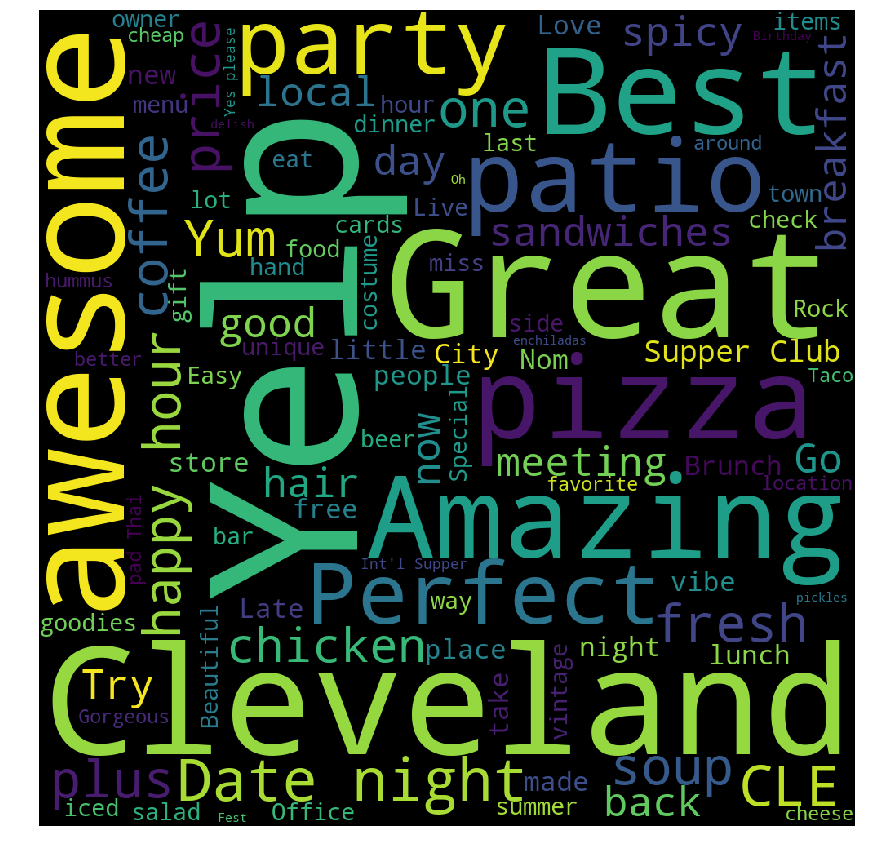

In [135]:
cloud = WordCloud(width=1000, height= 1000,max_words= 100).generate(' '.join(placeC['text']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');

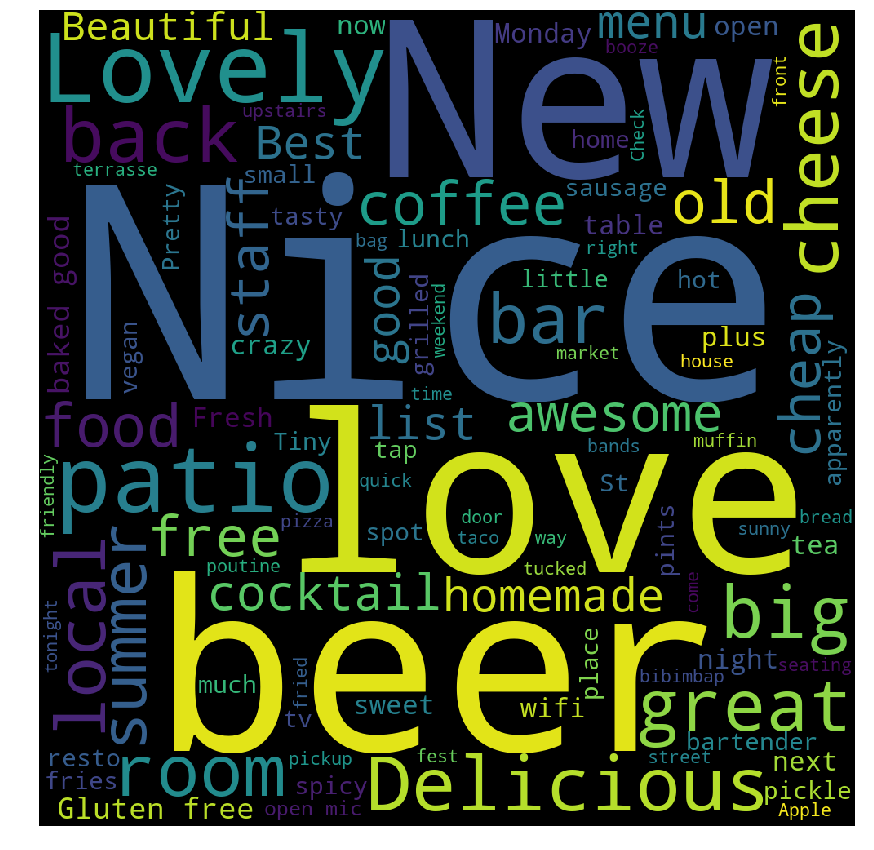

In [136]:
cloud = WordCloud(width=1000, height= 1000,max_words= 100).generate(' '.join(placeM['text']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');

In [ ]:
#choose a specific restaurant
#ask user to input a restaurant name
input_var = input("Enter restaurant name : ")
#restaurant="Earls Kitchen + Bar"


In [81]:
#word cloud
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 
from wordcloud import WordCloud



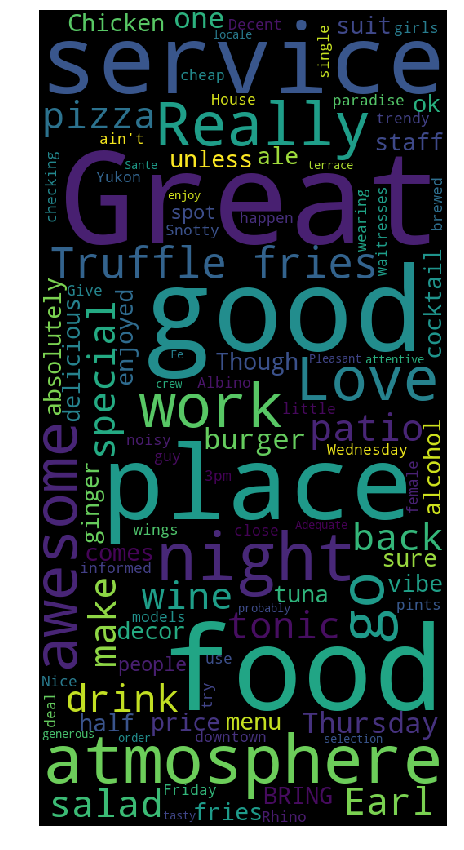

In [129]:
cloud = WordCloud(width=500, height= 1000,max_words= 100).generate(' '.join(newtip_df[(newtip_df['name']==restaurant)]['text']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');

In [86]:
#sentiment analytics
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list
    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

In [87]:
def do_pos_neg_sentiment_analysis(text_list,debug=False):
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    for text in text_list:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(text[1]):
            if word in positive_words:
                if debug:
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        results.append((text[0],cpos/len(word_tokenize(text[1])),cneg/len(word_tokenize(text[1]))))
    return results


In [ ]:
# placeT=places(activeT,newtip_df).drop_duplicates()
# placeL=places(activeL,newtip_df).drop_duplicates()
# placeC=places(activeC,newtip_df).drop_duplicates()
# placeM=

In [159]:
' '.join(placeL['text'])

"This place is cool! This is wonderful Smoke & choke supplies :) Woot woot I'm looking at new bags! Cool mall Can't wait to be home :) Memphis here I come. I love this place! Yey a huge king size bed :) I've been up all night in the casinos :) Mhm Very nice Don't come on Sunday they closed Bbq Great bbq Cool pizza This is my 2nd time here :) Woot woot This was fun I have a ball when I'm here On my way to the poker room :) Six dollars for this oooo a lake I love this park I found this cool park a few months ago and I really like chilling here on the weekends I'm drink n everyone under the table Cool place to chill I give it 3 stars I give it 3 stars I love the slots here. First time in This is cool :) Tip c I'm tip c $$$$$ Stop to play slots Omg these wings are soooo good Fun in vegas :) The chicken was boss Just exploring ... All things chocolate! Mhm yummie goodness Mhm These are the best! Healthy eating eat nothing unless your 3 year old can pronounced what's in it Vegas is sin city 

In [151]:
a=do_pos_neg_sentiment_analysis([('active user in Las Vegas',' '.join(placeL['text']))])
a

[('active user in Las Vegas', 0.06286415210058265, 0.01993253603189206)]

In [153]:
do_pos_neg_sentiment_analysis([('active user in Toronto',' '.join(placeT['text']))])

[('active user in Toronto', 0.026835443037974683, 0.010632911392405063)]

In [154]:
do_pos_neg_sentiment_analysis([('active user in Montreal',' '.join(placeM['text']))])

[('active user in Montreal', 0.04605776736924278, 0.0156128024980484)]

In [155]:
do_pos_neg_sentiment_analysis([('active user in Cleveland',' '.join(placeL['text']))])

[('active user in Cleveland', 0.06286415210058265, 0.01993253603189206)]

In [32]:
nrc = "data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
count=0
emotion_dict=dict()
with open(nrc,'r') as f:
    all_lines = list()
    for line in f:
        if count < 46:
            count+=1
            continue
        line = line.strip().split('\t')
        if int(line[2]) == 1:
            if emotion_dict.get(line[0]):
                emotion_dict[line[0]].append(line[1])
            else:
                emotion_dict[line[0]] = [line[1]]
        

In [158]:
def get_nrc_data():
    nrc = "data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count=0
    emotion_dict=dict()
    with open(nrc,'r') as f:
        all_lines = list()
        for line in f:
            if count < 46:
                count+=1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict

In [33]:
Luser=' '.join(placeL['text'])
Tuser=' '.join(placeT['text'])
Cuser=' '.join(placeC['text'])
Muser=' '.join(placeM['text'])

In [34]:
def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y}
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0

    #Analyze the text and normalize by total number of words
    total_words = len(text.split())
    for word in text.split():
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/len(text.split())
    return emotion_count
#emotion_analyzer(Luser,emotion_dict=emotion_dict)

In [35]:
def comparative_emotion_analyzer(text_tuples,object_name="users",print_output=False):
    if print_output:
        print("%-20s %1s\t%1s %1s %1s %1s   %1s %1s %1s %1s"%(object_name,
                                                              "fear","trust","negative","positive",
                                                              "joy","disgust","anticip", "sadness",
                                                              "surprise"))
    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
    
    output = df    
    for text_tuple in text_tuples:
        text = text_tuple[1] 
        result = emotion_analyzer(text)
        if print_output:
            print("%-20s %1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f"%(
                text_tuple[1][0:20],result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']))
        df.loc[text_tuple[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
    return output
#And test it        
comparative_emotion_analyzer([('user in Las Vegas',Luser),('user in Cleveland',Cuser),('user in Toronto',Tuser),('user in Montreal',Muser)])

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise
users,,,,,,,,,
user in Las Vegas,0.009869,0.031308,0.018207,0.073167,0.046112,0.007317,0.040327,0.008678,0.017866
user in Cleveland,0.005198,0.020793,0.012346,0.035088,0.019493,0.002599,0.018843,0.005198,0.008447
user in Toronto,0.005613,0.019646,0.010946,0.036767,0.019927,0.003087,0.019646,0.004210,0.010104
user in Montreal,0.006030,0.019481,0.018553,0.044991,0.031540,0.002319,0.019481,0.008813,0.010668


In [ ]:
# startipdf=newtip_df[['name','text','stars']]
# restaurantlist=newtip_df[(newtip_df['city']=='Toronto')]['name'].unique().tolist()
# funclist=[]
# for i in range(len(restaurantlist)):
#     text=startipdf[(startipdf['name']==restaurantlist[i])]['text']
#     #print(' '.join([startipdf[(startipdf['name']==restaurantlist[i])]['text']]))
#     funclist.append((restaurantlist[i],text))
    
    
# comparative_emotion_analyzer(funclist)
   

    
    
                
    
    

In [37]:
startipdf=newtip_df[['name','text','stars']]
Tlist=newtip_df[(newtip_df['city']=='Toronto')]['name'].unique().tolist()
LVlist=newtip_df[(newtip_df['city']=='Las Vegas')]['name'].unique().tolist()
Mlist=newtip_df[(newtip_df['city']=='Montréal')]['name'].unique().tolist()
Clist=newtip_df[(newtip_df['city']=='Cleveland')]['name'].unique().tolist()
Tlist

['Earls Kitchen + Bar',
 'Enoteca Sociale',
 'Rol San',
 'Korean Village Restaurant',
 "Fresco's Fish & Chips",
 'Sansotei Ramen',
 'Banh Mi Boys',
 'Under The Table Restaurant',
 'Cacao 70',
 "Balzac's Coffee",
 'Lee Chen Asian Bistro',
 'Wildly Delicious at the Distillery',
 'Pablo Cheesetart Canada',
 'Casa Loma',
 'CN Tower',
 'Toronto Zoo',
 '93 Harbord',
 'The Black Bull',
 'Le Papillon On Front',
 'Marché Restaurant',
 'Estiatorio VOLOS',
 'Olio',
 'EatThai',
 'OPA! of Greece North York City Centre',
 'Burrito Place',
 'Pai Northern Thai Kitchen',
 'The Rex Hotel Jazz & Blues Bar',
 'Terroni',
 'To-ne Sushi',
 'Ravi Soups',
 'Toronto Marriott City Centre Hotel',
 'Rosedale Diner',
 'The Lakeview',
 'The Stockyards',
 "Caplansky's Delicatessen",
 'The Ace',
 'Golden Patty',
 'OpenMat Mixed Martial Arts',
 'Homemade Ramen',
 "O'Grady's Restaurant",
 'St Lawrence Market',
 'Metro',
 'Yonge-Dundas Square',
 'Good View Restaurant',
 'The Pickle Barrel',
 'The Bata Shoe Museum',
 'Val

In [40]:
def getsentiment(startipdf,inputlist):
    funclist=[]
    for i in range(len(inputlist)):
        text=startipdf[(startipdf['name']==inputlist[i])]['text']
    #print(' '.join([startipdf[(startipdf['name']==restaurantlist[i])]['text']]))
        funclist.append((inputlist[i],text))
    
    return funclist
    #comparative_emotion_analyzer(funclist)
    

In [42]:
newT=getsentiment(startipdf,Tlist)
comparative_emotion_analyzer(newT)  

AttributeError: 'Series' object has no attribute 'split'

In [ ]:
getsentiment(startipdf,LVlist)

In [ ]:
getsentiment(startipdf,Mlist)

In [ ]:
getsentiment(startipdf,Clist)

In [20]:
startipdf=newtip_df[['name','text','stars']]


,name,text,stars
0,Earls Kitchen + Bar,"The place to go after work, but, it ain't cheap",3.5
1,Earls Kitchen + Bar,Patio! Drink Specials!,3.5
2,Earls Kitchen + Bar,Wednesday special ( 3pm to close). House brewe...,3.5
3,Earls Kitchen + Bar,Pizza is really good... Give it a try.,3.5
4,Earls Kitchen + Bar,Nice after work trendy atmosphere. Decent pric...,3.5
5,Earls Kitchen + Bar,Love Earl's but it is a little too noisy !,3.5
6,Earls Kitchen + Bar,Why on a Friday is this a female's paradise? ...,3.5
7,Earls Kitchen + Bar,Snotty service unless you're wearing a suit.,3.5
8,Earls Kitchen + Bar,Was just informed that they use models as wait...,3.5
9,Earls Kitchen + Bar,Pleasant attentive service. Sante Fe salad ver...,3.5
